In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import scipy
import pandas as pd
import scipy.sparse.linalg

In [20]:
data = pd.read_csv('data.csv')

data = np.array(data)   

X0 = data[:, 1:].T
Y0 = data[:, 0]

def choose_labels(labels):
    idx = [index for index, elem in enumerate(Y0) if elem in labels]

    X = X0[:, idx]     
    Y = Y0[idx]

    return X, Y

def split_data(X, Y, Ntrain):

    d, N = X.shape

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    Xtrain = X[:, train_idx]
    Ytrain = Y[train_idx]
    
    Xtest = X[:, test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)

chosen_digits = [3,6]

X, Y = choose_labels(chosen_digits)

Y[Y == chosen_digits[0]] = 0
Y[Y == chosen_digits[1]] = 1

Ntrain = int(0.6 * Y.shape[0])
(Xtrain, Ytrain), (Xtest, Ytest) = split_data(X, Y, Ntrain)


In [21]:
def l(w, x_hat, y):
    z = fw(x_hat, w)
    _, N = x_hat.shape
    y = np.reshape(y, (N,1))
    return (np.sum(MSE(z, y))/N)

def fw(xhat, w):
    return sigmoid(xhat.T @ w)

def sigmoid(z):
    return 1./(1 + np.exp(-z))

def MSE(y, y1):
    return ((np.linalg.norm(y - y1))**2)    

def grad_l(w, X_hat, Y):
    _, N = X_hat.shape
    sum = 0
    for i in range(N):
        z = fw(w, X_hat[:, i]) 
        sum += z * (1-z) * X_hat[:,i].T * (z-Y[i])
    return sum/N

def shuffle_data(X, Y, size):
    _, N = X.shape
    indexes = np.arange(N)
    np.random.shuffle(indexes)

    X_shuffle = X[:, indexes]
    Y_shuffle = Y[indexes]

    return X_shuffle, Y_shuffle

def SGD(l, grad_l, w0, D, batch_size, n_epochs, alpha=1e-5):
    X, Y = D  
    d, N = X.shape
    X = np.concatenate((np.ones((1,N)), X))
    d, N = X.shape

    n_batch_per_epoch = N//batch_size
    tot_batch = n_batch_per_epoch * n_epochs
    
    w = np.array(w0)
    f_val = np.zeros((n_epochs, ))
    grads = np.zeros((n_epochs, d))
    err = np.zeros((n_epochs,))
    w_vector = np.zeros((tot_batch, len(w0)))
      
    for epoch in range(n_epochs):
        X_shuffle, Y_shuffle = shuffle_data(X, Y, N//batch_size)
        
        for b in range (n_batch_per_epoch):  
            n = b*batch_size
            m = (b+1)*batch_size
            Mx = X_shuffle[:, n:m]
            My = Y_shuffle[n:m]

            w = w - alpha * grad_l(w, Mx, My)
            w_vector[epoch*n_batch_per_epoch + b, :] = w
            
        f_val[epoch] = l(w, X_shuffle, Y_shuffle)
        grads[epoch, :] = grad_l(w, X_shuffle, Y_shuffle)
        err[epoch] = np.linalg.norm(grad_l(w, X_shuffle, Y_shuffle))

    return w_vector, f_val, grads, err

In [37]:
d, N = Xtrain.shape
D = (Xtrain, Ytrain)

mean=0
sigma=1e-3
w0 = np.random.normal(mean, sigma, d+1)
batch_size = 15
n_epochs = 50

w, f_val, grads, err = SGD(l, grad_l, w0, D, batch_size, n_epochs, alpha=1e-5)


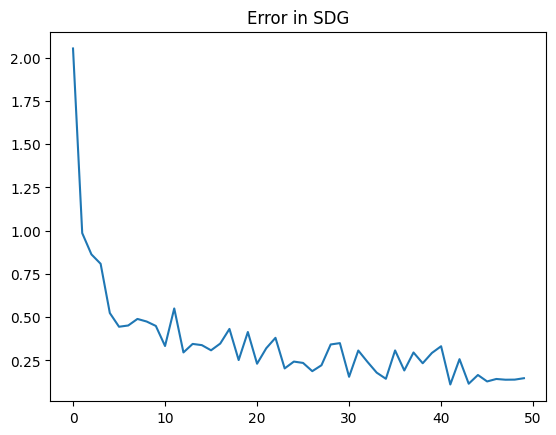

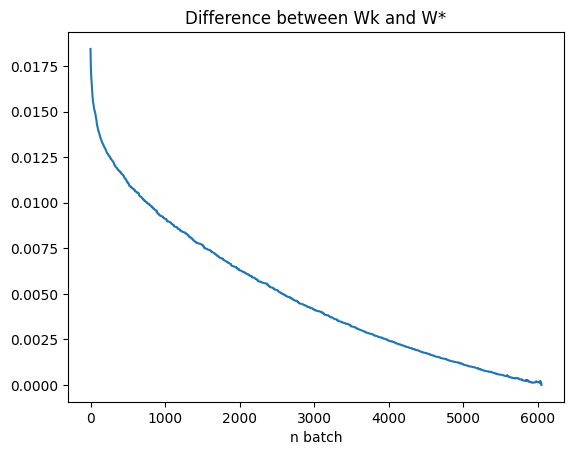

In [38]:
x_plot = np.arange(0,n_epochs)
plt.title("Error in SDG")
plt.plot(x_plot,err);
plt.show()


w_star = w[-1]
plt.title("Difference between Wk and W*")
diff = []
for ep in range(len(w)):
    diff.append(np.linalg.norm(w_star - w[ep,:]))
plt.plot(range(len(w)),diff);
plt.xlabel("n batch")
plt.show()

LOGISTIC REGRESSION

In [39]:
def accuracy(pred, label):
    N, = pred.shape
    correct = [pred == label]
    correct_sum = int(np.sum(correct))
    return correct_sum, correct_sum/N

def predict(w, X, treshold=0.5):
    z = fw(w, X)
    _, N = X.shape
    predictions = np.zeros((N,))
    predictions = z>treshold
    return predictions

d, N = Xtrain.shape
Xtrain_hat =  np.concatenate((np.ones((1,N)), Xtrain), axis=0)
ap = predict(w[-1], Xtrain_hat)
tot, accur = accuracy(ap, Ytrain)

print("Equals to 1 in train: ", np.sum(ap))
print("Total tests in train: ", N)
print("Total matches in train: ", tot)
print("Accuracy in train: ", accur*100,"%")

print() 

d, N_test = Xtest.shape
Xtest_hat =  np.concatenate((np.ones((1,N_test)), Xtest), axis=0)
ap = predict(w[-1], Xtest_hat)
tot, accur = accuracy(ap, Ytest)

print("Equals to 1: ", np.sum(ap))
print("Total tests: ", N_test)
print("Total matches: ", tot)
print("Accuracy: ", accur*100,"%")


Equals to 1 in train:  852
Total tests in train:  1817
Total matches in train:  1816
Accuracy in train:  99.94496422674739 %

Equals to 1:  3510
Total tests:  7268
Total matches:  7224
Accuracy:  99.39460649422125 %


COMPARISON WITH GD

In [40]:
def GD_2(l, grad_l, w0, D, tolf = 1e-9, tolx= 1e-9, kmax = 50, alpha = 1e-5):
    X, Y = D
    d, N = X.shape

    Xhat = np.concatenate((np.ones((1,N)), X), axis=0)
    
    w_vals = [w0]
    f_vals = [l(w0, Xhat, Y)]
    grad_f_vals = [grad_l(w0, Xhat, Y)]
    err_vals = [np.linalg.norm(grad_l(w0, Xhat, Y))]

    iterations = 0

    while iterations < kmax:
        w = w_vals[-1] - alpha * grad_l(w_vals[-1], Xhat, Y)

        w_vals.append(w)
        f_vals.append(l(w, Xhat, Y))
        grad_f_vals.append(grad_l(w, Xhat, Y))
        err_vals.append(np.linalg.norm(grad_l(w, Xhat, Y)))

        iterations+=1

        if err_vals[-1] < tolf * err_vals[0]:
            break

        if np.linalg.norm(w_vals[-1] - w_vals[-2]) < tolx * np.linalg.norm(w_vals[0]):
            break

    return w_vals, f_vals, grad_f_vals, err_vals, iterations

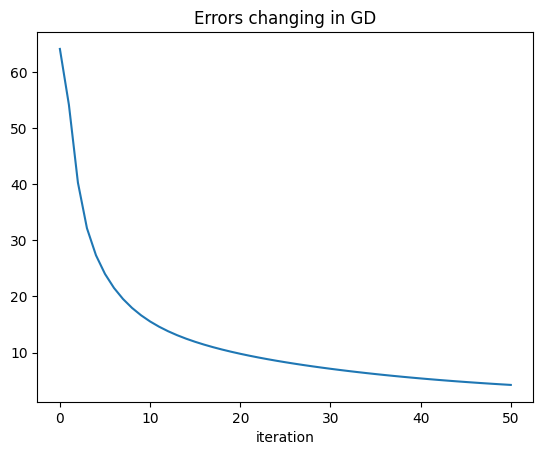

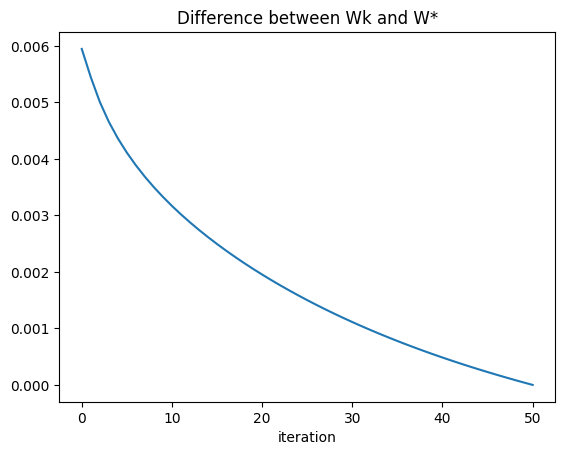

51


In [41]:
w_vec, f_vals_gd, grad_vals_gd, err_vals_gd, iterations_gd = GD_2(l, grad_l, w0, D)
w_gd = w_vec[-1]
x_plot = np.arange(len(err_vals_gd))
plt.plot(x_plot, err_vals_gd)
plt.title("Errors changing in GD")
plt.xlabel("iteration")
plt.show()

plt.title("Difference between Wk and W*")
diff = []
for ep in range(len(w_vec)):
    diff.append(np.linalg.norm(w_gd - w_vec[ep]))
plt.plot(range(len(w_vec)),diff);
plt.xlabel("iteration")
plt.show()
print(len(w_vec))

In [42]:
Xt = Xtrain.copy()
Yt = Ytrain.copy()

d, N = Xt.shape
Xthat = np.concatenate((np.ones((1,N)), Xt), axis=0)
app = predict(w_gd, Xthat)
tot, avg = accuracy(app, Yt)
print("Matches on Train Set:", int(tot))
print("Total entries on Train Set:", int(Yt.shape[0]))
print("Accuracy on Train Set:", round(avg*100, 2),"%\n")

Xt = Xtest.copy()
Yt = Ytest.copy()

d, N = Xt.shape
Xthat = np.concatenate((np.ones((1,N)), Xt), axis=0)
app = predict(w_gd, Xthat)
tot, avg = accuracy(app, Yt)
print("Matches on Test Set:", int(tot))
print("Total entries on Test Set:", int(Yt.shape[0]))
print("Accuracy on Test Set:", round(avg*100, 2),"%")

Matches on Train Set: 1770
Total entries on Train Set: 1817
Accuracy on Train Set: 97.41 %

Matches on Test Set: 7074
Total entries on Test Set: 7268
Accuracy on Test Set: 97.33 %


DIFFERENT DIGITS AND Ntrain (SGD)

In [43]:
chosen_digits = [1, 7]

X, Y = choose_labels(chosen_digits)

Y[Y == chosen_digits[0]] = 0
Y[Y == chosen_digits[1]] = 1

Ntrain = int(0.2 * Y.shape[0])
(Xtrain, Ytrain), (Xtest, Ytest) = split_data(X, Y, Ntrain)

d, N = Xtrain.shape
D = (Xtrain, Ytrain)

mean=0
sigma=1e-3
w0 = np.random.normal(mean, sigma, d+1)
batch_size = 15
n_epochs = 50

w, f_val, grads, err = SGD(l, grad_l, w0, D, batch_size, n_epochs, alpha=1e-5)

d, N = Xtrain.shape
Xtrain_hat =  np.concatenate((np.ones((1,N)), Xtrain), axis=0)
ap = predict(w[-1], Xtrain_hat)
tot, accur = accuracy(ap, Ytrain)

print("Equals to 1 in train: ", np.sum(ap))
print("Total tests in train: ", N)
print("Total matches in train: ", tot)
print("Accuracy in train: ", accur*100,"%")

print() 

d, N_test = Xtest.shape
Xtest_hat =  np.concatenate((np.ones((1,N_test)), Xtest), axis=0)
ap = predict(w[-1], Xtest_hat)
tot, accur = accuracy(ap, Ytest)

print("Equals to 1: ", np.sum(ap))
print("Total tests: ", N_test)
print("Total matches: ", tot)
print("Accuracy: ", accur*100,"%")

Equals to 1 in train:  902
Total tests in train:  1817
Total matches in train:  1815
Accuracy in train:  99.88992845349478 %

Equals to 1:  3507
Total tests:  7268
Total matches:  7216
Accuracy:  99.28453494771603 %


COMPARISON WITH PCA

In [66]:
def split(X, Y, Ntrain):
    _, N = X.shape
    totalIdxs = np.arange(N)
    np.random.shuffle(totalIdxs)
    indecesTrain = totalIdxs[:Ntrain]
    indecesTest = totalIdxs[Ntrain:]
    Xtrain = X[:, indecesTrain]
    Ytrain = Y[indecesTrain]
    Xtest = X[:, indecesTest]
    Ytest = Y[indecesTest]
    return (Xtrain, Ytrain, Xtest, Ytest)

def get_centroid(X):
    return np.mean(X, axis=1)

def get_clusters(Z, Y, choosen_numbers):
  clusters = list()
  for i in choosen_numbers:
    Ii = (Y==i)
    clusters.append(Z[:,Ii])
  return clusters

def concatenation(X_set,Y_set, chosen_indexes,):
  I = []
  chosen_X = []
  chosen_Y = []

  d, N = X_set.shape
  for element in chosen_indexes:
    I.append((Y_set == element))
  
  for i in range(len(chosen_indexes)):
    chosen_X.append(X_set[:,I[i]])
    
  for i in range(len(chosen_indexes)):
    chosen_Y.append(Y_set[I[i]])

  X_conc = np.concatenate(chosen_X, axis=1)
  Y_conc = np.concatenate(chosen_Y)
  return chosen_X, chosen_Y, X_conc, Y_conc

def distances(Z,Y_conc, choosen_numbers, type):
  clusters = get_clusters(Z, Y_conc, choosen_numbers)

  centroids = []
  for cluster in clusters:
    centroids.append(get_centroid(cluster))
  
  print("Distances from centroids:")
  for j in range(len(choosen_numbers)):
    tot = 0
    for i in range(0,len(clusters[j])):
        tot = tot + np.linalg.norm(clusters[j][:,i] - centroids[j])
    dist = tot / len(clusters[j])
    print("Average distance between elements in cluster " + str(choosen_numbers[j]) + " from "+ type + " and centroid: ",str(dist))
    
def PCA(X_set, Y_set, chosen_indexes, k):
    chosen_X, chosen_Y, X_conc, Y_conc = concatenation(X_set, Y_set, chosen_indexes)
    centroid = get_centroid(X_conc)
    centroid = np.reshape(centroid, (len(centroid), 1))
    Xc = X_conc - centroid
    U, S, Vh = np.linalg.svd(Xc, full_matrices=False)
    Uk = U[:, :k]
    return Uk.T@Xc, Uk.T, Y_conc

def accuracy(X, Y, P, choosen_numbers, clusters, type):
  acc = 0
  centroids = []
  for cluster in clusters:
    centroids.append(get_centroid(cluster))
  print()
  print("Accuracy in classification:")
  for i in range(X.shape[1]):
    x = X[:, i]
    projected_x = P @ x
    min_dist = np.linalg.norm(projected_x - centroids[0])
    selected_cluster = choosen_numbers[0]
    for j,num in enumerate(choosen_numbers):
      if(np.linalg.norm(projected_x - centroids[j]) < min_dist):
        min_dist = np.linalg.norm(projected_x - centroids[j])
        selected_cluster = num
    if(selected_cluster == Y[i]):
      acc += 1
  print("Total test for accuracy: ", X.shape[1])
  print("Total right guess for algorithm ", type, "= ", acc)
  acc /= X.shape[1]
  print("Accuracy is: ", acc*100, "%")
  
  

In [67]:
data = pd.read_csv('data.csv')

data = np.array(data)

X = data[:, 1:]
X = X.T
Y = data[:, 0]
d,N = X.shape

Ntrain = 35000
Xtrain, Ytrain, Xtest, Ytest = split(X, Y, Ntrain)
chosen_indexes = [0,9]
k = 2
Z_pca, projection_pca, Y_conc = PCA(Xtrain, Ytrain, chosen_indexes, k)
clusters = get_clusters(Z_pca, Y_conc, chosen_indexes)

chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtrain, Ytrain, chosen_indexes)
accuracy(X_conc, Y_conc, projection_pca, chosen_indexes, clusters, "pca")


Accuracy in classification:
Total test for accuracy:  6910
Total right guess for algorithm  pca =  6118
Accuracy is:  88.5383502170767 %


COMPARISON WITH LDA

In [68]:
def LDA(X_set,Y_set, chosen_indexes, k):
    d, N = X_set.shape
    chosen_X, chosen_Y, X_conc, Y_conc = concatenation(X_set,Y_set, chosen_indexes)

    centroids = []
    Xcs = []
    CX = get_centroid(X_conc)

    for element in chosen_X:
        centroids.append(get_centroid(element).reshape((d,1)))
    
    for i in range(len(chosen_indexes)):
        Xcs.append(chosen_X[i] - centroids[i])

    Xw = np.concatenate(Xcs, axis=1)
    Sw = Xw @ Xw.T

    X_s = []
    for i in range(len(centroids)):
        X_s.append(np.repeat(centroids[i], chosen_X[i].shape[1], axis=1))
        
    X_ = np.concatenate(X_s, axis=1)
    X_c = X_ - CX.reshape((d, 1))
    Sb = X_c @ X_c.T

    L = []
    try: 
        L = np.linalg.cholesky(Sw)
    except:
        eps = 1e-6
        Sw = Sw + eps * np.eye(Sw.shape[0])
        L = np.linalg.cholesky(Sw)

    W = np.linalg.inv(L) @ Sb @ L
    _, W = scipy.sparse.linalg.eigs(W,k=k)
    W = np.real(W)
    Q = np.linalg.inv(L).T @ W
    Z = Q.T @ X_conc
    return Z, Q.T, Y_conc

In [69]:
Z_pca, projection_pca, Y_conc = LDA(Xtrain, Ytrain, chosen_indexes, k)
clusters = get_clusters(Z_pca, Y_conc, chosen_indexes)

chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtrain, Ytrain, chosen_indexes)
accuracy(X_conc, Y_conc, projection_pca, chosen_indexes, clusters, "lda")


Accuracy in classification:
Total test for accuracy:  6910
Total right guess for algorithm  lda =  6881
Accuracy is:  99.58031837916064 %
